In [16]:
import numpy as np
import matplotlib.pyplot as plt

# load data from the npz file
data = np.load('sparse_freq_RDE_results_validation_data.npz')

# print the keys in the data to understand its structure
print("Data keys:", data.files)
U_real_full= data['U_real_full']
U_real_valid= data['U_real_valid']
results_lf_only= data['results_lf_only']
results_lf_hf= data['results_lf_hf']
hf_true_valid= data['hf_true_valid']
hf_pred_valid= data['hf_pred_valid']
hf_pred_fft_valid= data['hf_pred_fft_valid']
history_sensor_loss= data['history_sensor_loss']
history_sparsity_loss= data['history_sparsity_loss']
error_valid= data['error_valid']

N, T = U_real_valid.shape

Data keys: ['U_real_full', 'idx_valid', 'U_sim_full', 'U_real_valid', 'results_lf_only', 'results_lf_hf', 'hf_true_valid', 'hf_pred_valid', 'hf_pred_fft_valid', 'history_sensor_loss', 'history_sparsity_loss', 'error_valid']


    Plotting detailed results (VALIDATION data)...


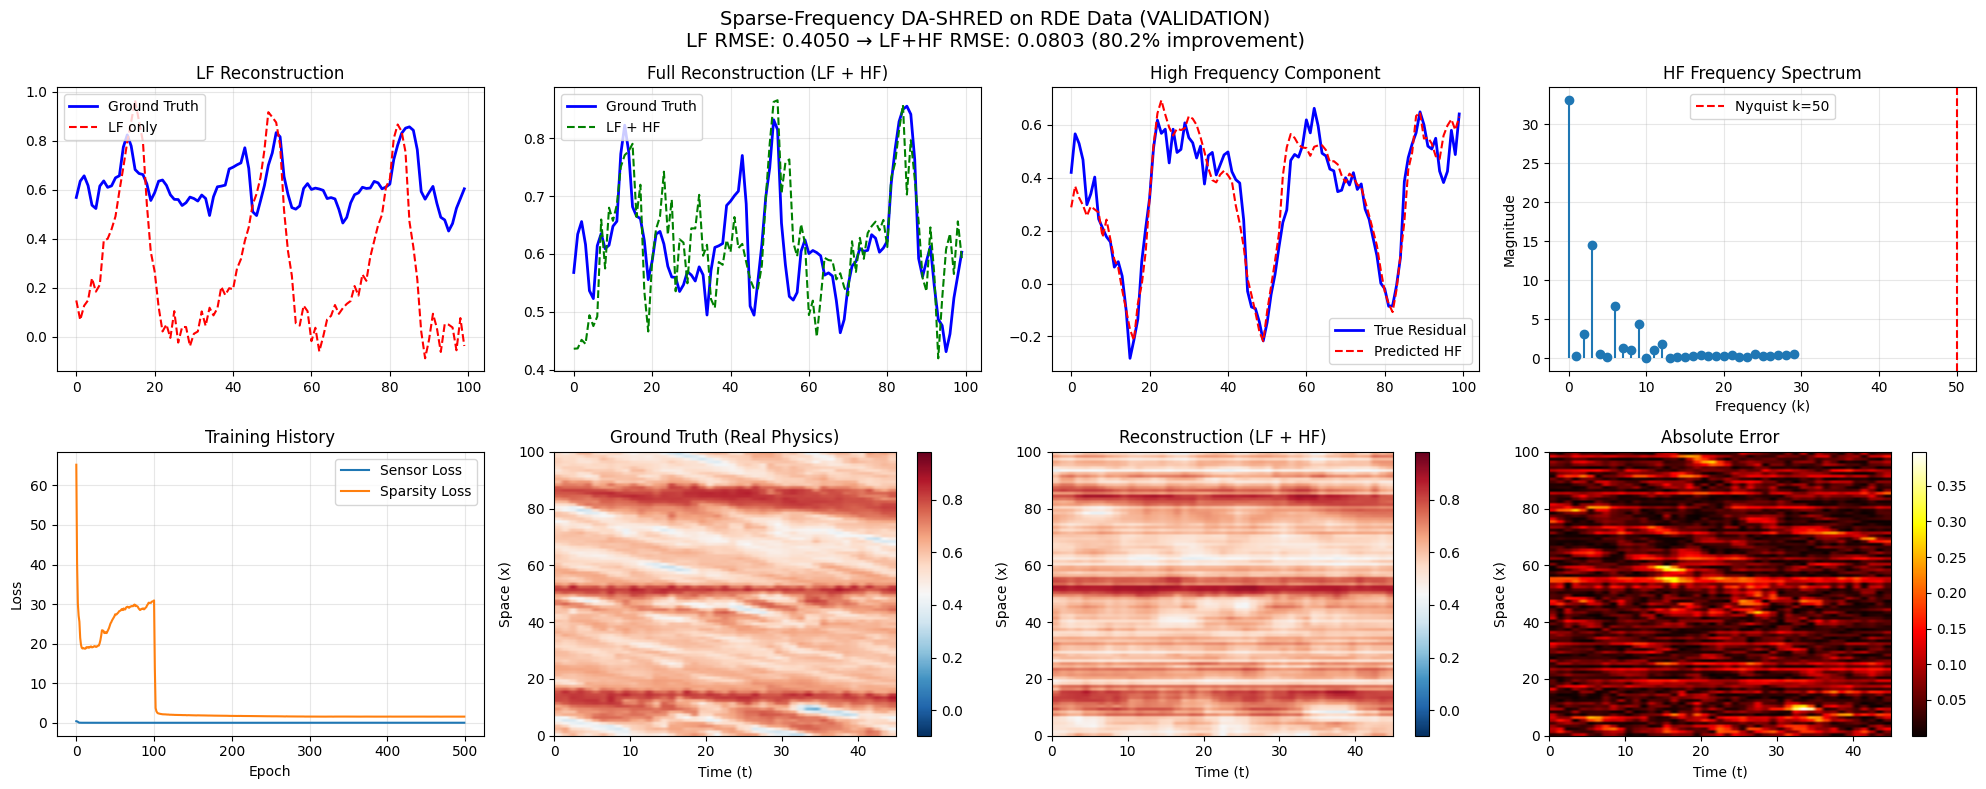

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Load data locally if not in memory (cell 1 usually does this)
# data = np.load('sparse_freq_RDE_results_validation_data.npz')

# Extract variables from the loaded data
# We use the 'valid' datasets from the npz to reconstruct the detailed plots
U_valid = data['U_real_valid']       # Ground truth for validation
U_pred_lf = data['results_lf_only']  # LF prediction
U_pred_total = data['results_lf_hf'] # LF + HF prediction
hist_sensor = data['history_sensor_loss']
hist_sparsity = data['history_sparsity_loss']
error = data['error_valid']

# The saved idx_valid might be a 0-d array (scalar)
idx_slice = int(data['idx_valid']) 

# Dimensions
T_valid, N_sensors = U_valid.shape
x = np.arange(N_sensors)

print(f"    Plotting detailed results (VALIDATION data)...")
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

# Find global min/max for consistent colorbars across Ground Truth / Prediction
all_data = [U_valid, U_pred_total, U_pred_lf]
vmin = min(d.min() for d in all_data)
vmax = max(d.max() for d in all_data)

# Extent for imshow: [t_min, t_max, x_min, x_max]
extent = [0, T_valid, 0, N_sensors]

# === Row 1: 1D Spatial slices at time `idx_slice` ===

# 1. LF Reconstruction
axes[0, 0].plot(x, U_valid[idx_slice], 'b-', lw=2, label='Ground Truth')
axes[0, 0].plot(x, U_pred_lf[idx_slice], 'r--', lw=1.5, label='LF only')
axes[0, 0].set_title('LF Reconstruction')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Full Reconstruction (LF + HF)
axes[0, 1].plot(x, U_valid[idx_slice], 'b-', lw=2, label='Ground Truth')
axes[0, 1].plot(x, U_pred_total[idx_slice], 'g--', lw=1.5, label='LF + HF')
axes[0, 1].set_title('Full Reconstruction (LF + HF)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. HF Component comparison
# Calculate residuals at this slice
hf_true_slice = U_valid[idx_slice] - U_pred_lf[idx_slice]
hf_pred_slice = U_pred_total[idx_slice] - U_pred_lf[idx_slice]

axes[0, 2].plot(x, hf_true_slice, 'b-', lw=2, label='True Residual')
axes[0, 2].plot(x, hf_pred_slice, 'r--', lw=1.5, label='Predicted HF')
axes[0, 2].set_title('High Frequency Component')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. HF Frequency Spectrum
# Compute FFT of the predicted HF component
fft_vals = np.abs(np.fft.rfft(hf_pred_slice))
freqs = np.arange(len(fft_vals))

axes[0, 3].stem(freqs[:30], fft_vals[:30], basefmt=' ')
axes[0, 3].axvline(N_sensors // 2, color='r', linestyle='--', label=f'Nyquist k={N_sensors // 2}')
axes[0, 3].set_xlabel('Frequency (k)')
axes[0, 3].set_ylabel('Magnitude')
axes[0, 3].set_title('HF Frequency Spectrum')
axes[0, 3].legend()
axes[0, 3].grid(alpha=0.3)

# === Row 2: Training History and Spatiotemporal Heatmaps ===

# 5. Training History
axes[1, 0].plot(hist_sensor, label='Sensor Loss')
axes[1, 0].plot(hist_sparsity, label='Sparsity Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training History')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 6. Ground Truth Heatmap
im1 = axes[1, 1].imshow(U_valid.T, aspect='auto', cmap='RdBu_r',
                        origin='lower', vmin=vmin, vmax=vmax, extent=extent)
axes[1, 1].set_title('Ground Truth (Real Physics)')
axes[1, 1].set_xlabel('Time (t)')
axes[1, 1].set_ylabel('Space (x)')
plt.colorbar(im1, ax=axes[1, 1])

# 7. Reconstruction Heatmap
im2 = axes[1, 2].imshow(U_pred_total.T, aspect='auto', cmap='RdBu_r',
                        origin='lower', vmin=vmin, vmax=vmax, extent=extent)
axes[1, 2].set_title('Reconstruction (LF + HF)')
axes[1, 2].set_xlabel('Time (t)')
axes[1, 2].set_ylabel('Space (x)')
plt.colorbar(im2, ax=axes[1, 2])

# 8. Error Heatmap
im3 = axes[1, 3].imshow(error.T, aspect='auto', cmap='hot', origin='lower', extent=extent)
axes[1, 3].set_title('Absolute Error')
axes[1, 3].set_xlabel('Time (t)')
axes[1, 3].set_ylabel('Space (x)')
plt.colorbar(im3, ax=axes[1, 3])

# Calculate and display RMSE metrics
rmse_lf = np.sqrt(np.mean((U_pred_lf - U_valid) ** 2))
rmse_total = np.sqrt(np.mean((U_pred_total - U_valid) ** 2))
improvement = (rmse_lf - rmse_total) / rmse_lf * 100

plt.suptitle(f'Sparse-Frequency DA-SHRED on RDE Data (VALIDATION)\n'
             f'LF RMSE: {rmse_lf:.4f} → LF+HF RMSE: {rmse_total:.4f} '
             f'({improvement:.1f}% improvement)', fontsize=14)

plt.tight_layout()
plt.show()